# Make plots of layer orientation

Requires master_orientation.py has already been run

## Import packages

In [1]:
# general
import numpy as np
import pandas as pd
import math
from scipy import stats

# plotting
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# math
from statsmodels.stats.weightstats import DescrStatsW

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Set Filepaths

In [2]:
path_to_angles = '../../data/angles/'
path_to_figures = '../../../figures/paper_figures/'

## Load Angle Data

Requires that master_orientation.py has already been run

In [3]:
alhic2302 = pd.read_pickle(path_to_angles+'alhic2302_angles.df')
alhic2201 = pd.read_pickle(path_to_angles+'alhic2201_angles.df')

## Adjust Aparent Dip for geometry

All aparent dip is calculated in the same reference frame. However, we need to flip one of the two faces for both cores to achieve our definition of a positive dip as sloping down from the center of the core. This means flipping 't' on ALHIC2201 and 'l' on ALHIC2302

In [4]:
# multiply all angles in 'AC-l-angles' by -1 in alhic2302
for index,row in alhic2302.iterrows():
    alhic2302.at[index,'AC-l-angles'] = list(map(lambda x: x * -1, row['AC-l-angles']))

# multiply all angles in 'AC-t-angles' by -1 in alhic2201
for index,row in alhic2201.iterrows():
    alhic2201.at[index,'AC-t-angles'] = list(map(lambda x: x * -1, row['AC-t-angles']))

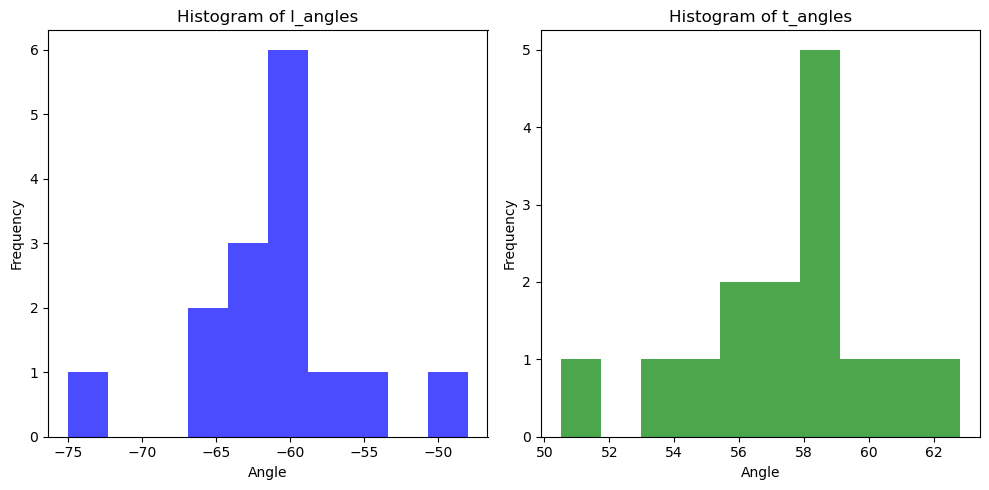

In [5]:
row = alhic2302[alhic2302['section'] == '40']

l_angles = row['AC-l-angles'].dropna().to_list()
t_angles = row['AC-t-angles'].dropna().to_list()

# make a histogram of l_angles and t_angles
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# plot histogram for l_angles
ax[0].hist(l_angles[0], bins=10, color='blue', alpha=0.7)
ax[0].set_title('Histogram of l_angles')
ax[0].set_xlabel('Angle')
ax[0].set_ylabel('Frequency')

# plot histogram for t_angles
ax[1].hist(t_angles[0], bins=10, color='green', alpha=0.7)
ax[1].set_title('Histogram of t_angles')
ax[1].set_xlabel('Angle')
ax[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()



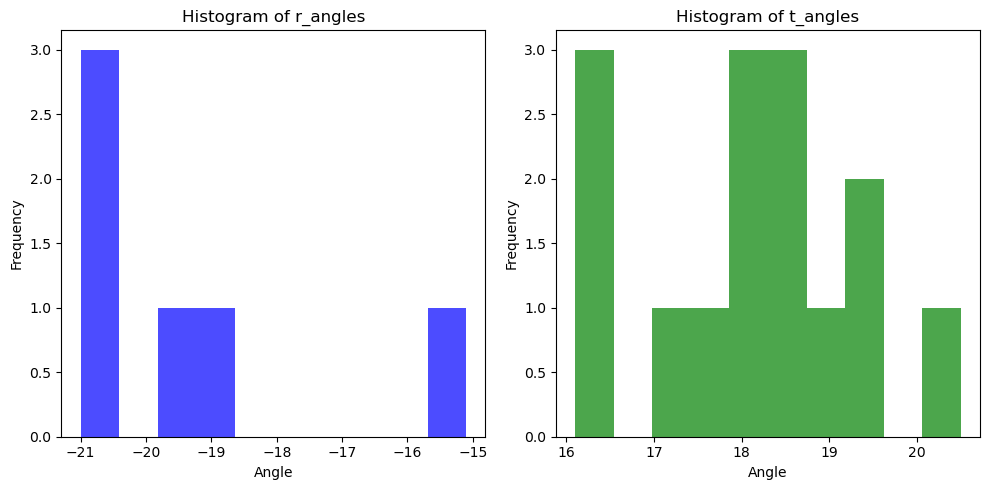

In [6]:
row = alhic2201[alhic2201['section'] == '26_1']

r_angles = row['AC-r-angles'].dropna().to_list()
t_angles = row['AC-t-angles'].dropna().to_list()

# make a histogram of l_angles and t_angles
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# plot histogram for l_angles
ax[0].hist(r_angles[0], bins=10, color='blue', alpha=0.7)
ax[0].set_title('Histogram of r_angles')
ax[0].set_xlabel('Angle')
ax[0].set_ylabel('Frequency')

# plot histogram for t_angles
ax[1].hist(t_angles[0], bins=10, color='green', alpha=0.7)
ax[1].set_title('Histogram of t_angles')
ax[1].set_xlabel('Angle')
ax[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


## Calculate True Angle Orientations

In [7]:
# define function to calculate true dip, dip direction, and score

def calc_dip(df,face):

    dip = []
    dip_direction = []
    dip_score = []
    for index,row in df.iterrows():

        # pull out values from the side (first check there are three)
        if row['AC-'+face+'-angles'] != None and len(row['AC-'+face+'-angles']) > 2:
            add_nan = False
            side_angle = np.array(row['AC-'+face+'-angles']) * np.pi/180
            side_score = np.array(row['AC-'+face+'-scores'])
            side_length = np.array(row['AC-'+face+'-length'])
        else:
            add_nan = True

        # pull out values from the top
        if row['AC-t-angles'] != None and len(row['AC-t-angles']) > 2:
            top_angle = np.array(row['AC-t-angles']) * np.pi/180
            top_score = np.array(row['AC-t-scores'])
            top_length = np.array(row['AC-t-length'])
        else:
            add_nan = True
        

        # set true angle to nan if we don't have enough data
        if add_nan:
            dip_score_ind = [np.nan]
            dip_dir_ind = [np.nan]
            dip_ind = [np.nan]
        
        # else, calculate dip and save to list
        else:

            # assign delta 1 and delta 2
            if face == 'l':
                d1 = top_angle
                d2 = side_angle
                
                d1_score = top_score * top_length
                d2_score = side_score * side_length
                
            elif face == 'r':
                
                d1 = side_angle
                d2 = top_angle

                d1_score = side_score * side_length
                d2_score = top_score * top_length
            else:
                print('Error: face must be either t or l')
                break

            # make empty lists
            dip_score_ind = []
            dip_dir_ind = []
            dip_ind = []

            for i in range(len(d2)):
                for j in range(len(d1)):

                    # calculate dip score
                    ds = d1_score[j] * d2_score[i]
                    dip_score_ind.append(ds)

                    # calculate dip direction
                    dd = np.arctan(np.tan(d2[i])/np.tan(d1[j])) 
                    dip_dir_ind.append(dd* 180 / np.pi)

                    # calculate true dip
                    d = np.arctan(np.tan(d1[j])/np.cos(dd))
                    dip_ind.append(d* 180 / np.pi)


        # append to lists
        dip.append(dip_ind)
        dip_direction.append(dip_dir_ind)
        dip_score.append(dip_score_ind)

    df['AC-dip'] = dip
    df['AC-dip-direction'] = dip_direction
    df['AC-dip-score'] = dip_score

    return df

In [8]:
alhic2302 = calc_dip(alhic2302,'l')
alhic2201 = calc_dip(alhic2201,'r')

## Define function to get weighted percentile

In [9]:
def weighted_percentile(values, weights, percentiles):
    
    # Convert percentiles to fractions
    percentiles = [p / 100 for p in percentiles]

    # Convert values and weights to numpy arrays
    values = np.array(values)
    weights = np.array(weights)
    percentiles = np.array(percentiles)

    # Check for NaN values and remove them
    nan_mask = np.isnan(values) | np.isnan(weights)
    if np.any(nan_mask):
        print("NaN values found and will be removed.")
    values = values[~nan_mask]
    weights = weights[~nan_mask]
    
    # Sort values and weights by values
    sorted_indices = np.argsort(values)
    sorted_values = values[sorted_indices]
    sorted_weights = weights[sorted_indices]
    
    # Compute the cumulative sum of weights
    cumulative_weights = np.cumsum(sorted_weights)
    
    # Normalize the cumulative weights to get the cumulative distribution
    cumulative_distribution = cumulative_weights / cumulative_weights[-1]
    
    # Interpolate to find the weighted percentiles
    weighted_percentiles = np.interp(percentiles, cumulative_distribution, sorted_values)
    
    return weighted_percentiles

## Calulate Percentiles

In [10]:
# define function to calculate percentiles from dataframe with true dip angles
def calc_percentiles(df,percentiles):

    # initialize list to store dip statistics
    dip_stats = []
    # define if we are looking at AC or DC (AC is default)
    ACorDC = 'AC'

    # loop through each row in the dataframe
    for index,row in df.iterrows():

        # pull out approriate data
        dip = np.array(row[ACorDC+'-dip'])
        scores = np.array(row[ACorDC+'-dip-score'])

        # check there isn't one value, indicating nan
        if len(dip)>1:
        
            # plot dip
            a = weighted_percentile(dip, scores, percentiles)
            # weighted_percentile(dip, percentiles, weights=scores, interpolation='step')
            dip_stats.append(a)

            # check
            for i in range(len(a)-1):
                if a[i]>a[i+1]:
                    print('Error: Percentiles are not in order in section '+row['section'])
        else:
            dip_stats.append([np.nan]*len(percentiles))

    df['dip_percentiles'] = dip_stats
    return df

In [11]:
#set percentiles
percentiles = [10,25,50,75,90]

# calculate true dip percentiles for alhic2201 and alhic2302
alhic2201 = calc_percentiles(alhic2201,percentiles)
alhic2302 = calc_percentiles(alhic2302,percentiles)

## Rotate dip direction to match geometry

In [12]:
# first up, we have to rotate the dip direction by 180 for all sections where the median dip is negative.

# define function to rotate dip direction by 180 if median dip is negative
def rotate_dip_direction(df):

    # loop through each row in the dataframe
    for index,row in df.iterrows():

        # pull out approriate data
        dip = np.array(row['dip_percentiles'][2])
        #dip_dir = np.array(row['AC-dip-direction'])

        # check if the median dip is negative
        if dip < 0:

            # save to dataframe
            df.at[index,'AC-dip-direction'] = np.array(row['AC-dip-direction']) + 180
    
        # ensure all angles in df.at[index,'AC-dip-direction'] are between 0 and 360 (check for both >360 and <0). df.at[index,'AC-dip-direction'] is a list.
        df.at[index,'AC-dip-direction'] = [angle - 360 if angle > 360 else angle for angle in df.at[index,'AC-dip-direction']]
        df.at[index,'AC-dip-direction'] = [angle + 360 if angle < 0 else angle for angle in df.at[index,'AC-dip-direction']]

    return df

alhic2201 = rotate_dip_direction(alhic2201)
alhic2302 = rotate_dip_direction(alhic2302)


In [13]:
# Now we have to set dip direction to be angles from the orientation line. We're already set for alhic2302, but we need to subtract 90 degrees for alhic2302.
# We accomplish this by adding 270 and taking the modulo 360.

#subtract 90 degrees from dip direction in alhic2302
for index,row in alhic2302.iterrows():
 alhic2302.at[index,'AC-dip-direction'] = list(map(lambda x: (x + 270)%360, row['AC-dip-direction']))


## Report Results

In [14]:
# Report the total number of sections in each of alhic2201 and alhic2302, and the number wehre the AC-dip is not nan
print('Total number of sections in alhic2201: '+str(len(alhic2201)))
print('Number of sections with AC-dip in alhic2201: '+str(len(alhic2201[~alhic2201['AC-dip'].apply(lambda x: np.isnan(x).all())])))
print('Total number of sections in alhic2302: '+str(len(alhic2302)))
print('Number of sections with AC-dip in alhic2302: '+str(len(alhic2302[~alhic2302['AC-dip'].apply(lambda x: np.isnan(x).all())])))

# report the number of sections from each core where the interquartile range is <20 degrees:
print('Number of sections in alhic2201 where the interquartile range is <20 degrees: '+str(len(alhic2201[alhic2201['dip_percentiles'].apply(lambda x: x[3]-x[1]<20)])))
print('Number of sections in alhic2302 where the interquartile range is <20 degrees: '+str(len(alhic2302[alhic2302['dip_percentiles'].apply(lambda x: x[3]-x[1]<20)])))

# report the median and standard deviation of the dip for each core (excluding sections where the interquartile range is >20 degrees)
median_dip_2201 = alhic2201[alhic2201['dip_percentiles'].apply(lambda x: x[3] - x[1] < 20)]['dip_percentiles'].apply(lambda x: abs(x[2])).mean()
std_dip_2201 = alhic2201[alhic2201['dip_percentiles'].apply(lambda x: abs(x[3] - x[1]) < 20)]['dip_percentiles'].apply(lambda x: abs(x[2])).std()
median_dip_2302 = alhic2302[alhic2302['dip_percentiles'].apply(lambda x: x[3] - x[1] < 20)]['dip_percentiles'].apply(lambda x: abs(x[2])).mean()
std_dip_2302 = alhic2302[alhic2302['dip_percentiles'].apply(lambda x: abs(x[3] - x[1]) < 20)]['dip_percentiles'].apply(lambda x: abs(x[2])).std()

print('Median dip for alhic2201 (excluding sections with IQR > 20 degrees):', median_dip_2201)
print('Standard deviation of dip for alhic2201 (excluding sections with IQR > 20 degrees):', std_dip_2201)
print('Median dip for alhic2302 (excluding sections with IQR > 20 degrees):', median_dip_2302)
print('Standard deviation of dip for alhic2302 (excluding sections with IQR > 20 degrees):', std_dip_2302)

# calculate the total number of sections in both cores combined
total_sections = len(alhic2201) + len(alhic2302)
# calculate the total number of sections which meet the IQR threshold
total_good_sections = len(alhic2201[alhic2201['dip_percentiles'].apply(lambda x: x[3] - x[1] < 20)]) + len(alhic2302[alhic2302['dip_percentiles'].apply(lambda x: x[3] - x[1] < 20)])
# report the percentage of sections which meet the IQR threshold
print('Percentage of sections which meet the IQR threshold:', total_good_sections / total_sections * 100)

Total number of sections in alhic2201: 23
Number of sections with AC-dip in alhic2201: 17
Total number of sections in alhic2302: 39
Number of sections with AC-dip in alhic2302: 36
Number of sections in alhic2201 where the interquartile range is <20 degrees: 16
Number of sections in alhic2302 where the interquartile range is <20 degrees: 33
Median dip for alhic2201 (excluding sections with IQR > 20 degrees): 28.63413531713931
Standard deviation of dip for alhic2201 (excluding sections with IQR > 20 degrees): 5.905105575710423
Median dip for alhic2302 (excluding sections with IQR > 20 degrees): 68.27083339667318
Standard deviation of dip for alhic2302 (excluding sections with IQR > 20 degrees): 3.6347530643177355
Percentage of sections which meet the IQR threshold: 79.03225806451613


## Make a plot of depth vs dip

In [15]:
# define plotting function (adds interquartile range and median to plot)
def plotstats(d,q,axs,mindip,maxdip):
    
    h = 0.8
    linewidth=1


        
    #box
    axs.add_patch(Rectangle((q[1],d-h/2),(q[3]-q[1]),
                            h,
                            facecolor='k',
                            edgecolor='k',
                            linewidth=1,
                            alpha=0.5))

    # median (change color based on IQR)
    if abs(q[3]-q[1]) > 20:
        axs.plot([q[2],q[2]],[d-h/2,d+h/2],'r',linewidth=3)
    else:
        axs.plot([q[2],q[2]],[d-h/2,d+h/2],'b',linewidth=3)
    
    # centerile
    axs.plot([mindip,maxdip],[d,d],'k',linewidth=linewidth)    


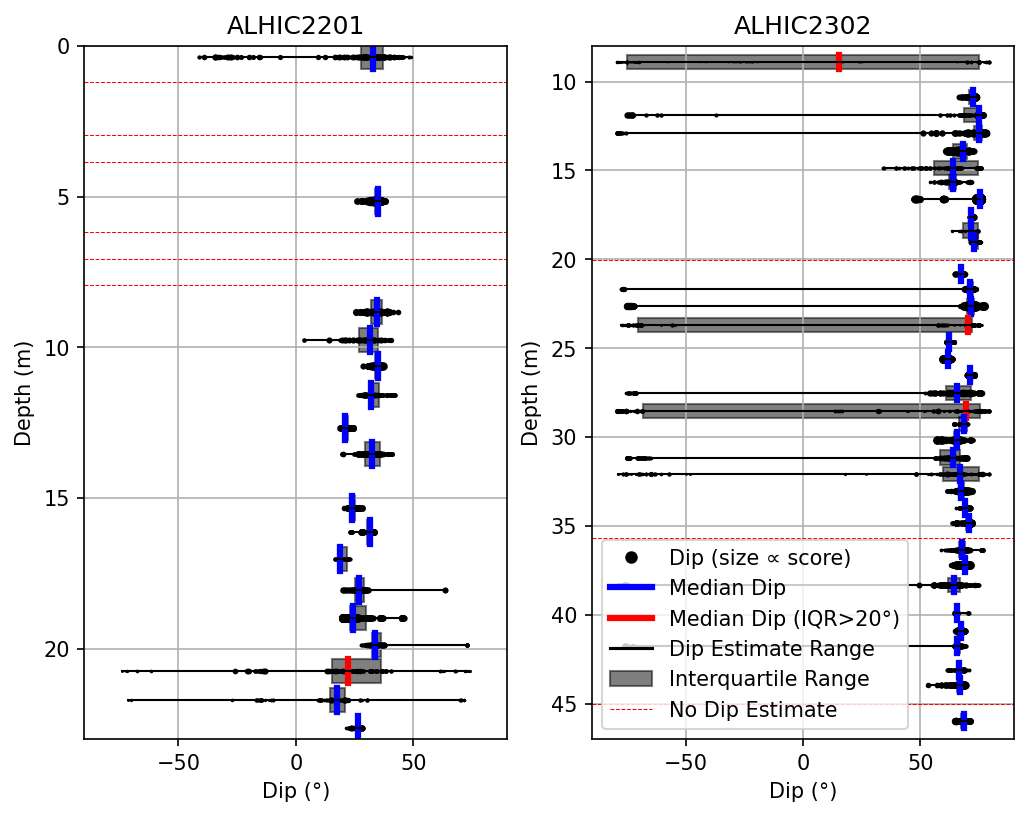

In [16]:
# make figure
fig, ax = plt.subplots(1,2,figsize=(8,6),dpi=150)

# axis labels
for a in ax:
    a.set_ylabel('Depth (m)')
    a.set_xlabel('Dip (°)')
    a.set_xlim(-90,90)
    a.grid(True)
ax[0].set_title('ALHIC2201')
ax[1].set_title('ALHIC2302')
ax[0].invert_yaxis()
ax[1].invert_yaxis()
ax[0].set_ylim(23,0)
ax[1].set_ylim(47,8)

def plot_dip(df,ax):
    for index,row in df.iterrows():

         # pull out values for this section
        d = row['depth']
        dip = np.array(row['AC-dip'])
        scores = np.array(row['AC-dip-score'])
        dip_percentile = row['dip_percentiles']

        # check if row dip is nan
        if np.isnan(dip).all():
            ax.plot([-90,90],[d,d],'r--',linewidth=0.5)
        else:

            # check if median dip is negative. If it is, flip for plotting purposes
            if dip_percentile[2] < 0:
                dip_percentile = [i*-1 for i in dip_percentile]
                dip = [i*-1 for i in dip]
                #print("flipping dip on section "+row['section'])

            # plot dip (individual points)
            for i in range(len(dip)):
                ax.plot(dip[i],d,'k.',markersize=scores[i]*10)

            # plot dip statistics
            plotstats(d,dip_percentile,ax,min(dip),max(dip))

# plot alhic2201 and alhic2302
plot_dip(alhic2201,ax[0])
plot_dip(alhic2302,ax[1])

# add legend (to left subplot only)
ax[1].plot([],[],'k.',markersize=10,label='Dip (size ∝ score)')
ax[1].plot([],[],'b',linewidth=3,label='Median Dip')
ax[1].plot([],[],'r',linewidth=3,label='Median Dip (IQR>20°)')
ax[1].plot([],[],'k-',label='Dip Estimate Range')
ax[1].add_patch(Rectangle((0,0),0,0,facecolor='k',edgecolor='k',alpha=0.5,label='Interquartile Range'))
ax[1].plot([],[],'r--',linewidth=0.5,label='No Dip Estimate')
ax[1].legend(loc='lower left')

# save figure
plt.savefig(path_to_figures+'/dip_estimates.png')

## Now make a plot showing orientation with depth

First we calculate the circular weighted mean. I define a function for this below.

Then we make a plot. This will exclude all core sections which exceed the interquartile threshold. 

In [17]:
# function to calculate circular mean
def calc_circular_mean(df):

    for index,row in df.iterrows():
        
        # pull out approriate data
        angles = np.array(row['AC-dip-direction'])
        weights = np.array(row['AC-dip-score'])
        
        # convert to radians
        angles = np.radians(angles)
        
        # compute the mean
        x = np.sum(np.cos(angles)*weights)
        y = np.sum(np.sin(angles)*weights)
        
        # convert back to degrees
        mean = np.degrees(np.arctan2(y,x))

        # convert to 0-360
        if mean < 0:
            mean = mean + 360
        
        # store the circular mean
        df.loc[index,'dip-direction-mean'] = mean
    
    return df

In [18]:
# impliment function, calc circular mean
alhic2201 = calc_circular_mean(alhic2201)
alhic2302 = calc_circular_mean(alhic2302)

In [19]:
# set threshold to ignore
threshold = 20

# define core breaks
alhic2201_breaks = [17.62,17.65,24.08]
alhic2302_breaks = [10.37,19.73,20.39,24.28,30.72,39.53,40.47,41.39,42.7]

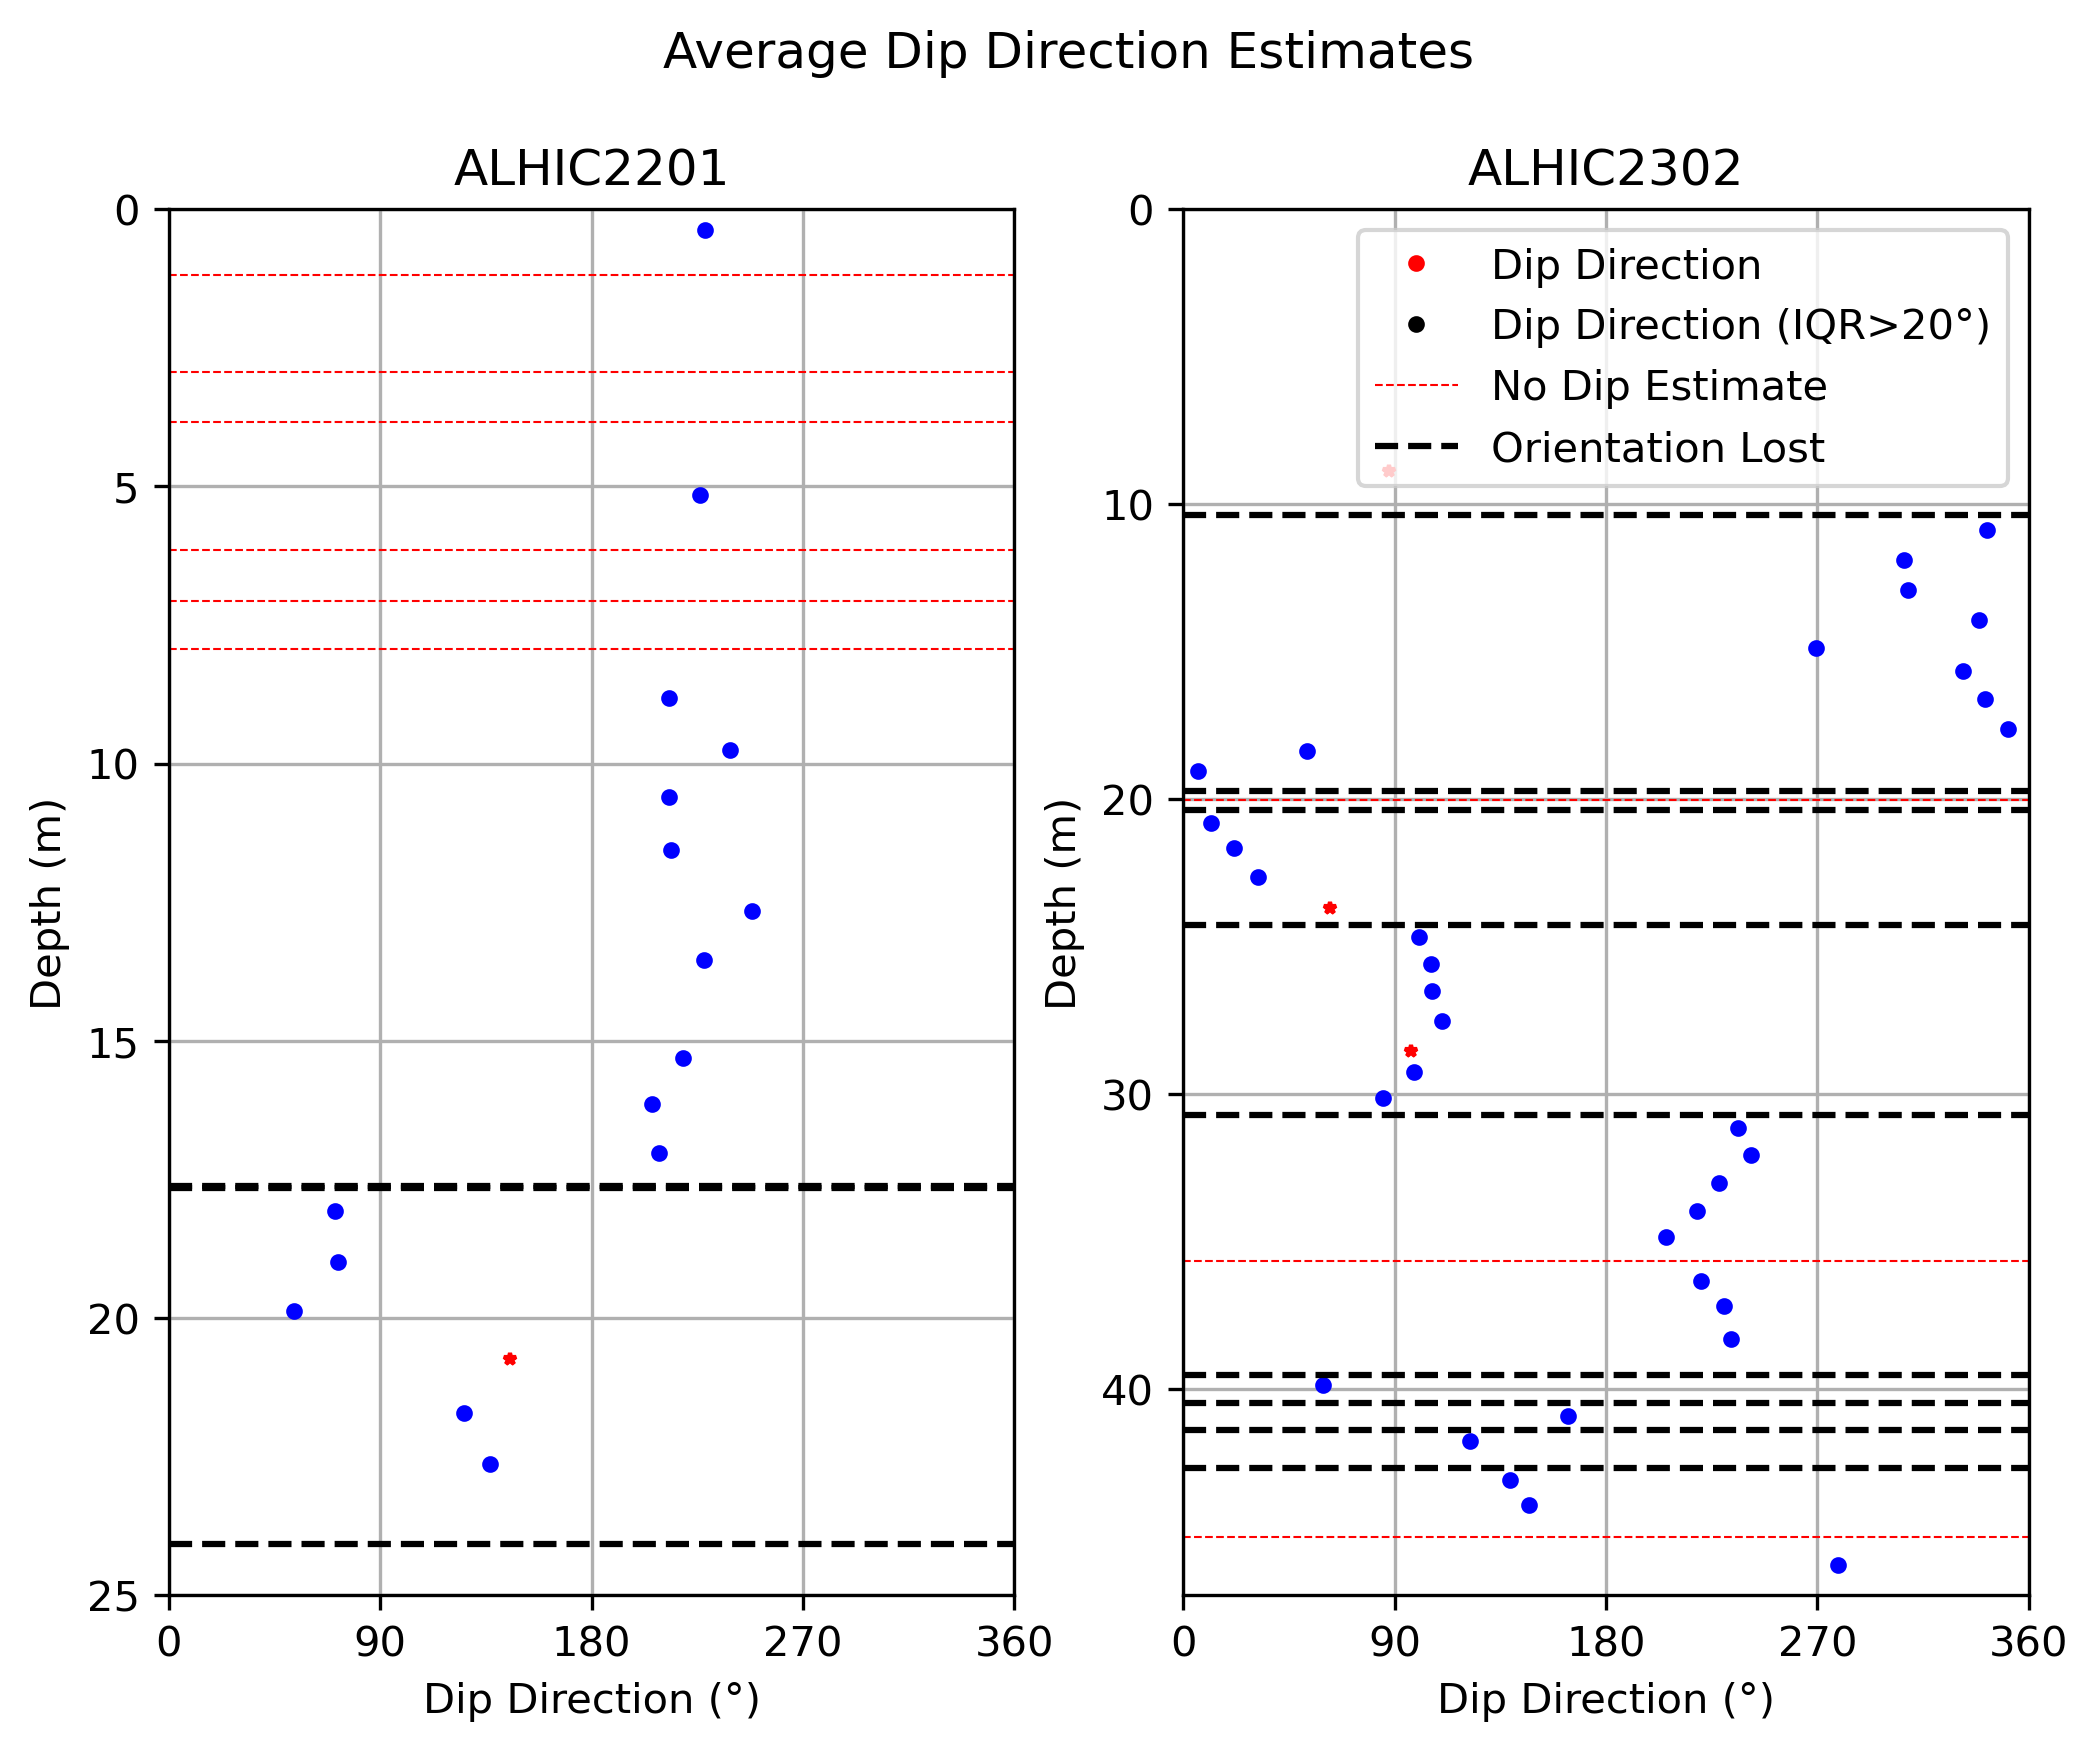

In [20]:
# make figure
fig, ax = plt.subplots(1,2,figsize=(8,6),dpi=300)

for a in ax:
    a.set_ylabel('Depth (m)')
    a.set_xlabel('Dip Direction (°)')
    a.grid(True)
    a.set_xlim(0,360)
    # set x axis grid to be in 90 degree increments
    a.set_xticks(np.arange(0,361,90))

ax[0].set_ylim(25,0)
ax[1].set_ylim(47,0)

def plot_dip_directions(df, ax, core_breaks, threshold,core):
    # plot dip directions
    for index, row in df.iterrows():
        # pull out values
        d = row['depth']
        dip = row['dip_percentiles'][2]
        q1 = row['dip_percentiles'][1]
        q3 = row['dip_percentiles'][3]
        dir = row['dip-direction-mean']

        # check for nan
        if np.isnan(dip):
            ax.plot([0, 360], [d, d], 'r--', linewidth=0.5)
        else:

            # # flip if dip is negative
            # NOW MOVED ABOVE
            # if dip < 0:
            #     orientation = (row['dip-direction-mean'] + 180) % 360
            # else:
            #     orientation = row['dip-direction-mean']

            # check if exceeding value
            if abs(q3 - q1) < threshold:
                ax.plot(row['dip-direction-mean'], d, 'bo', markersize=3)
            else:
                ax.plot(row['dip-direction-mean'], d, 'r*', markersize=3)


    # plot core breaks
    for b in core_breaks:
        ax.plot([0, 360], [b, b], 'k--')

    # add title 
    ax.set_title(core)

# Apply the function to both dataframes
plot_dip_directions(alhic2201, ax[0], alhic2201_breaks, threshold,'ALHIC2201')
plot_dip_directions(alhic2302, ax[1], alhic2302_breaks, threshold,'ALHIC2302')

# add legend (to right subplot only)
ax[1].plot([],[],'ro',markersize=3,label='Dip Direction')
ax[1].plot([],[],'ko',markersize=3,label='Dip Direction (IQR>20°)')
ax[1].plot([],[],'r--',linewidth=0.5,label='No Dip Estimate')
ax[1].plot([],[],'k--',label='Orientation Lost')
ax[1].legend(loc = 'upper right')
fig.suptitle('Average Dip Direction Estimates')

# save figure
plt.savefig(path_to_figures+'/dip_direction.png')

## Save the dataframes

This let's us save the dataframes to a pickle file for later use, including the orientation data and dip we calculate here

In [21]:
# Save Output Dataframe with simple angle information

# loop through both dataframes and save them (overwriting current file)
for df,core in zip([alhic2201,alhic2302],['ALHIC2201','ALHIC2302']):

    df['median-dip'] = df['dip_percentiles'].apply(lambda x: abs(x[2]))
    df['IQR']= df['dip_percentiles'].apply(lambda x: x[3]-x[1])
    

    # save just the dip and dip direction as a csv
    df[['section','depth','median-dip','dip-direction-mean','IQR']].to_csv(path_to_angles+core+'_simple_dip.csv',index=False)

## Get ALHIC2201 Azimuth

Core logs for ALHIC2201 Identify that the orientation line at the surface points 59 degrees E of Magnetic North. We can use this to find the azimuth of the direction of steepest dip

In [22]:
# find average dip in ALHIC2201 above the first core break
alhic2201_above_break = alhic2201[alhic2201['depth'] < alhic2201_breaks[0]]
# filter for where the IQR is less than 20
alhic2201_above_break = alhic2201_above_break[alhic2201_above_break['dip_percentiles'].apply(lambda x: x[3]-x[1]<20)]
average_dip_direction = alhic2201_above_break['dip-direction-mean'].mean()
std_dip_direction = alhic2201_above_break['dip-direction-mean'].std()
print("Average Dip Direction above the first orientation lost is "+str(round(average_dip_direction,1)))
print("Standard Deviation of Dip Direction above the first orientation lost is "+str(round(std_dip_direction,1)))

#Move into degrees east framework
o_line_azimuth = 59
dip_azimuth = o_line_azimuth - average_dip_direction

print("ALHIC2201 Dip azimuth is "+str(round((dip_azimuth+360)%360,1))+" degrees E of N")

Average Dip Direction above the first orientation lost is 222.1
Standard Deviation of Dip Direction above the first orientation lost is 13.2
ALHIC2201 Dip azimuth is 196.9 degrees E of N


## Make Plot showing trend with depth

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Excluding ALHIC2201 24_1
-22.099376474981685
Excluding ALHIC2302 10
-15.421863071816395
Excluding ALHIC2302 26
-70.39893327123617
Excluding ALHIC2302 31
-69.34623601673015


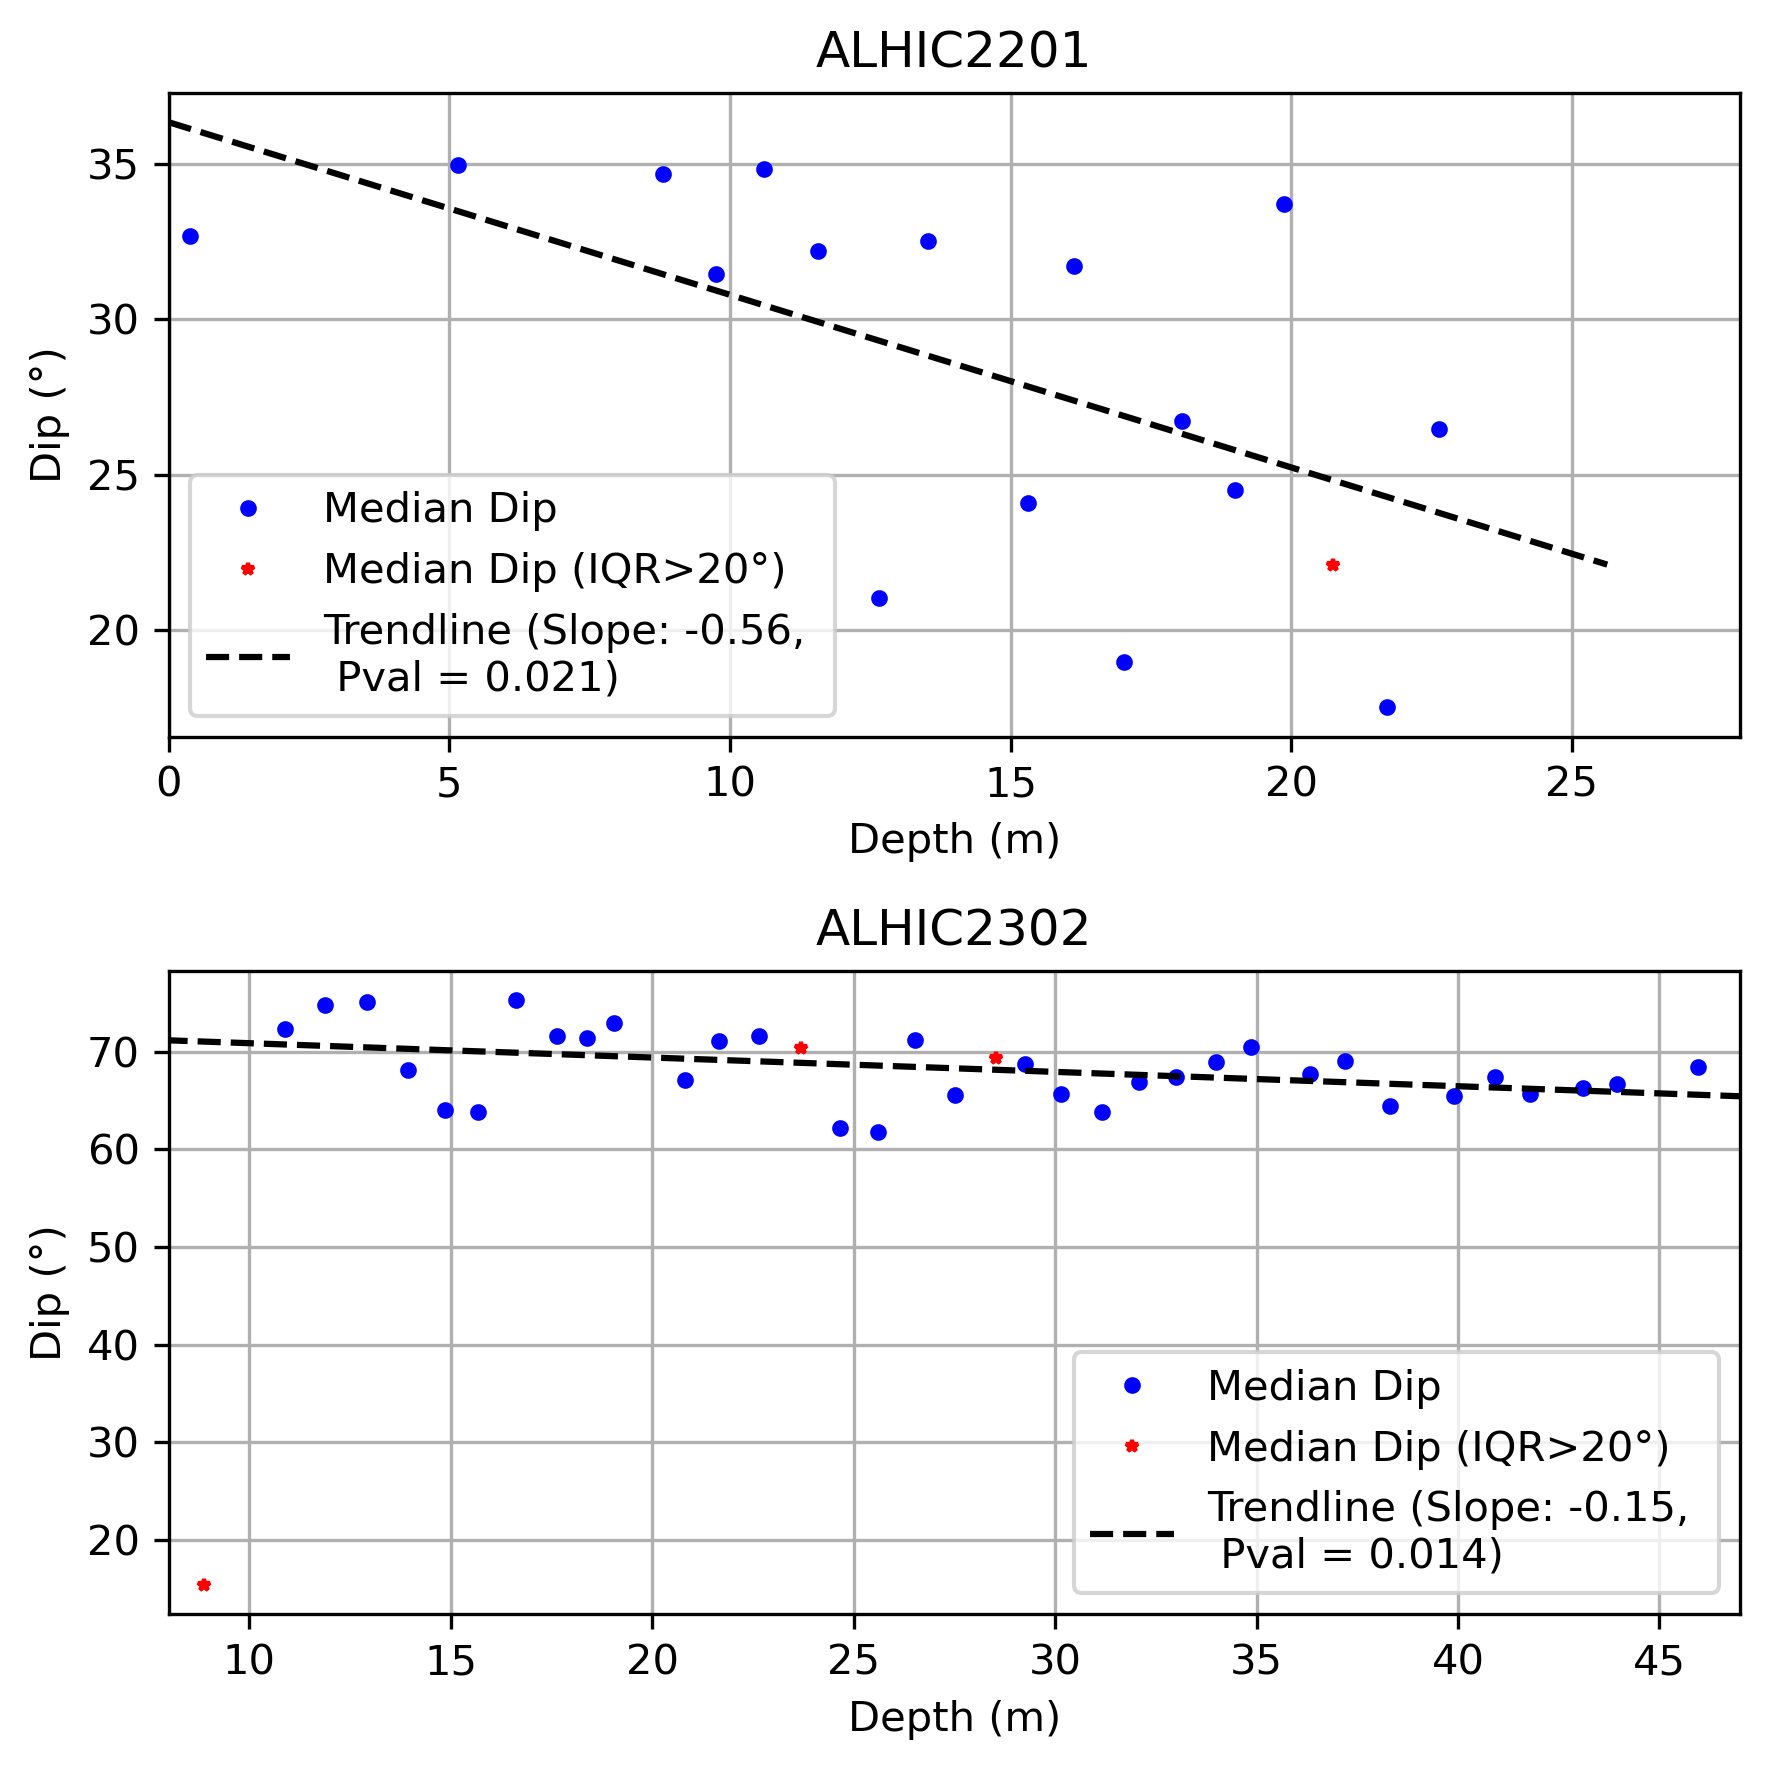

In [23]:
# set threshold to ignore
threshold = 20

def t_test_trend(df,threshold):

    # pull out median dip
    dip = np.array(df['dip_percentiles'].apply(lambda x:x[2]))
    q1 = np.array(df['dip_percentiles'].apply(lambda x:x[1]))
    q3 = np.array(df['dip_percentiles'].apply(lambda x:x[3]))

    # pull out depth and interquartile range
    depth = np.array(df['depth'])

    # remove nan from dip and depth vectors
    depth = depth[~np.isnan(dip)]
    q1 = q1[~np.isnan(dip)]
    q3 = q3[~np.isnan(dip)]
    dip = dip[~np.isnan(dip)]

    # pull out depth/dip values which exceed an interquartile range of 40
    depth = depth[abs(q3-q1)<threshold]
    dip = dip[abs(q3-q1)<threshold]

    # perform t-test
    slope, intercept, r_value, p_value, std_err = stats.linregress(depth,abs(dip))

    return slope,intercept,p_value,depth,dip

# calculate t-test for alhic2201 and alhic2302
slope2201,intercept2201,p_value2201,depth2201,dip2201 = t_test_trend(alhic2201,threshold)
slope2302,intercept2302,p_value2302,depth2302,dip2302 = t_test_trend(alhic2302,threshold)

# make figure
fig, ax = plt.subplots(2,1,figsize=(6,6),dpi=300)
for a in ax:
    a.set_xlabel('Depth (m)')
    a.set_ylabel('Dip (°)')
    a.set_xlim(0,90)
    a.grid(True)
ax[0].set_title('ALHIC2201')
ax[1].set_title('ALHIC2302')
ax[0].set_xlim(0,28)
ax[1].set_xlim(8,47)

# plot data
#for ax,slope,intercept,p_value,depth,dip in zip(ax,[slope2201,slope2302],[intercept2201,intercept2302],[p_value2201,p_value2302],[depth2201,depth2302],[dip2201,dip2302]):

for ax,slope,intercept,p_value,df,core in zip(ax,[slope2201,slope2302],[intercept2201,intercept2302],[p_value2201,p_value2302],[alhic2201,alhic2302],['ALHIC2201','ALHIC2302']):

    # plot data
    label1 = True
    label2 = True
    for index,row in df.iterrows():

        d = row['depth']
        dip = row['dip_percentiles'][2]
        
        # check for nan
        if not np.isnan(dip):

            q1 = row['dip_percentiles'][1]
            q3 = row['dip_percentiles'][3]

            if abs(q3-q1)<threshold:
                #print("Including "+core+' '+row['section'])
                if label1:
                    ax.plot(d,abs(dip),'bo',markersize=3,label='Median Dip')
                    label1 = False
                else:
                    ax.plot(d,abs(dip),'bo',markersize=3)
            else:
                print("Excluding "+core+' '+row['section'])
                print(dip)
                if label2:
                    ax.plot(d,abs(dip),'r*',markersize=3,label='Median Dip (IQR>20°)')
                    label2 = False
                else:
                    ax.plot(d,abs(dip),'r*',markersize=3)

    # plot trendline
    label = f'Trendline (Slope: {slope:.2f}, \n Pval = {p_value:.3f})'
    ax.plot([0,max(df['depth'])+3],[intercept,intercept+slope*(max(df['depth'])+3)],'k--', label=label)

    handles, labels = ax.get_legend_handles_labels()
    order = [labels.index('Median Dip')] + [i for i in range(len(labels)) if i != labels.index('Median Dip')]
    ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order])
plt.tight_layout()

# save figure
plt.savefig(path_to_figures+'trendline.png',dpi=300)
